## ELEC5307-2021-S2: Project 1 report

### Pulin Zhang (530128780)

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

The default colab uses CPU, you can add GPU resources in Runtime->Change runtime type->dropdown, select GPU->save

**Note: the following code is written for cpu, you need to allocate data and network to GPU on your own if you want to utilize GPU devices.**

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss.

### 1.1 prepare data

In [ ]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=True,
                                        download=True, transform=transform)
trainset = [item for item in trainset]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=False,
                                       download=True, transform=transform)
testset = [item for item in testset]
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Number of trainset:", len(trainset))


100%|██████████| 170498071/170498071 [00:11<00:00, 14928892.67it/s]


Extracting /tmp/CIFAR10/cifar-10-python.tar.gz to /tmp/CIFAR10
Files already downloaded and verified
Number of trainset: 50000


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [ ]:
from torch.utils.data import random_split

# Define the number of images for validation
validation_size = 5000

# Calculate the size of the new training set
new_training_size = len(trainset) - validation_size

# Split the training set into a new training set and a validation set
new_trainset, validationset = random_split(trainset, [new_training_size, validation_size])

# Create data loaders for the new training set and validation set
new_trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=4, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=4, shuffle=False, num_workers=2)

print("Number of samples in new_trainloader:", len(new_trainloader.dataset))
print("Number of samples in validationloader:", len(validationloader.dataset))


Number of samples in new_trainloader: 45000
Number of samples in validationloader: 5000


### 1.3 Define a Baseline Convolution Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 1.4 Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 1.5 Train the network

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(new_trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.275
[1,  4000] loss: 2.067
[1,  6000] loss: 1.940
[1,  8000] loss: 1.797
[1, 10000] loss: 1.686
[2,  2000] loss: 1.576
[2,  4000] loss: 1.554
[2,  6000] loss: 1.519
[2,  8000] loss: 1.488
[2, 10000] loss: 1.451
Finished Training


### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model. You may need to change some of the codes in 1.5 in order to save the loss into different lists.

Epoch [1/2] Train Loss: 1.940  Train Acc: 28.12% Validation Loss: 1.713  Validation Acc: 38.54%
Epoch [2/2] Train Loss: 1.503  Train Acc: 45.58% Validation Loss: 1.473  Validation Acc: 47.78%
Finished Training


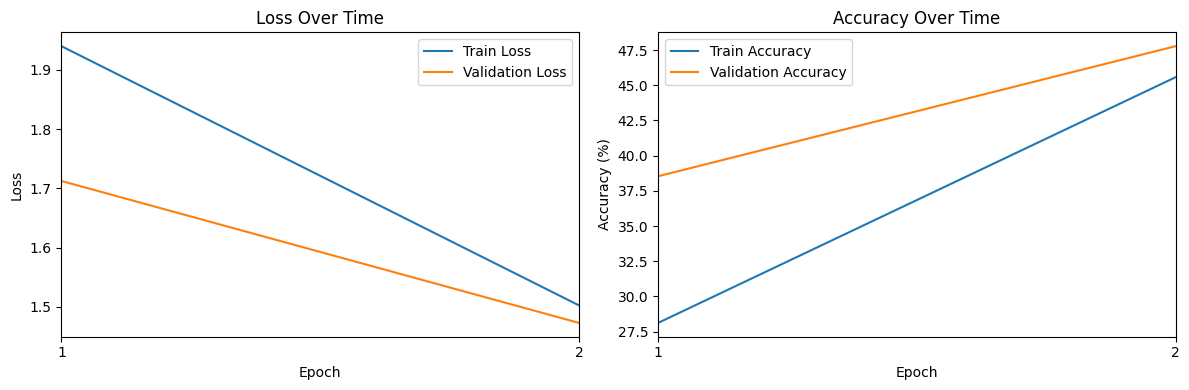

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt

# Define a function to train the model and record loss and accuracy
def train_and_visualize(net, trainloader, validationloader, criterion, optimizer, num_epochs=2):
    train_losses = []  # To store training losses
    validation_losses = []  # To store validation losses
    train_accuracy = []  # To store training accuracy
    validation_accuracy = []  # To store validation accuracy

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        net.train()  # Set the model in training mode

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracy.append(100 * correct_train / total_train)

        # Validation loss and accuracy
        net.eval()  # Set the model in evaluation mode
        correct_val = 0
        total_val = 0
        validation_loss = 0.0

        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_losses.append(validation_loss / len(validationloader))
        validation_accuracy.append(100 * correct_val / total_val)

        print(f'Epoch [{epoch + 1}/{num_epochs}]'
              f' Train Loss: {train_losses[-1]:.3f} '
              f' Train Acc: {train_accuracy[-1]:.2f}%'
              f' Validation Loss: {validation_losses[-1]:.3f} '
              f' Validation Acc: {validation_accuracy[-1]:.2f}%')

    print('Finished Training')

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Time')
    plt.xlim(1, num_epochs)  # Set x-axis range
    plt.xticks(range(1, num_epochs + 1))  # Set x-axis labels from 1 to num_epochs

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracy, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Over Time')
    plt.xlim(1, num_epochs)  # Set x-axis range
    plt.xticks(range(1, num_epochs + 1))  # Set x-axis labels from 1 to num_epochs

    plt.tight_layout()
    plt.show()

# Create and initialize the model
net = Net()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Define the number of epochs
num_epochs = 2

# Train and visualize the model
train_and_visualize(net, new_trainloader, validationloader, criterion, optimizer, num_epochs)


### 1.7 Eval the trained network

In [ ]:
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

eval_net(net, testloader)

Accuracy of the network on the 10000 test images: 47 %


### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size:8
2. Base learning rate:0.001
3. Number of epochs:16

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

**Answer**:Firstly,i used my experience to get rid of epochs 1,2 ,which is very far from fine tuned and complete learning of model.Secondly i abandoned batch size 2 .It is so small that it could lead to overfitting and very slow convergence.Thirdly ,i took a try of 0.005,0.00001 and they are either too small or too big for this model.Finally i try all rest hyperparameters for all possible combinations and get the most suitable hyperparameters.Here are all possibilities.(epoches=16).when learning rate is 0.001 and batch size=8,the validation accuracy curve and training curve fit very well ,so it is best combiantion.  

Training with batch_size=4, lr=0.001, epochs=16


100%|██████████| 170498071/170498071 [00:01<00:00, 107306559.12it/s]


Extracting /tmp/CIFAR10/cifar-10-python.tar.gz to /tmp/CIFAR10
Epoch [16/16] Train Loss: 0.834  Train Acc: 70.14% Validation Loss: 1.340  Validation Acc: 57.46%


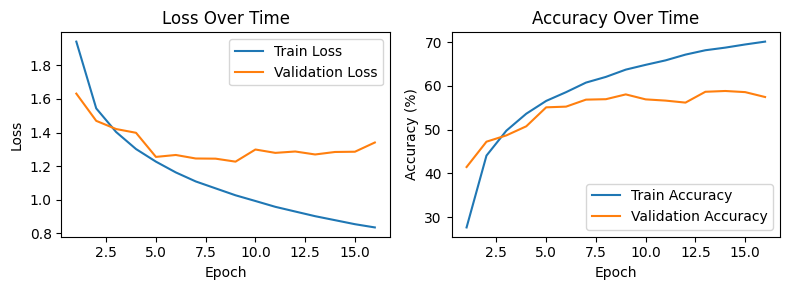

Training with batch_size=4, lr=0.0005, epochs=16
Files already downloaded and verified
Epoch [16/16] Train Loss: 0.777  Train Acc: 72.29% Validation Loss: 1.204  Validation Acc: 61.04%


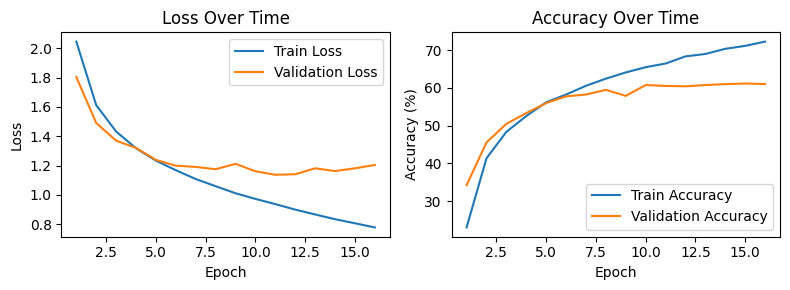

Training with batch_size=4, lr=0.0001, epochs=16
Files already downloaded and verified
Epoch [16/16] Train Loss: 1.200  Train Acc: 57.22% Validation Loss: 1.260  Validation Acc: 55.78%


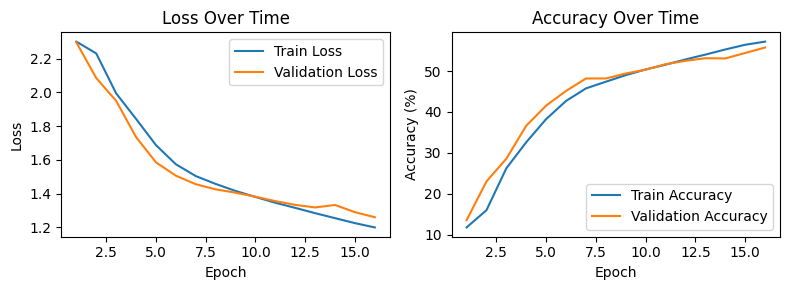

Training with batch_size=4, lr=5e-05, epochs=16
Files already downloaded and verified
Epoch [16/16] Train Loss: 1.413  Train Acc: 48.97% Validation Loss: 1.430  Validation Acc: 48.74%


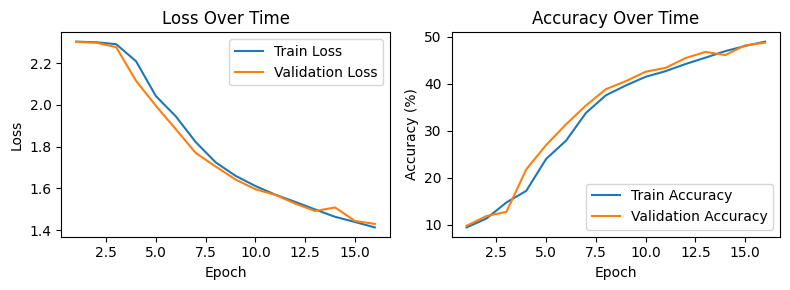

Training with batch_size=8, lr=0.001, epochs=16
Files already downloaded and verified
Epoch [16/16] Train Loss: 0.826  Train Acc: 70.30% Validation Loss: 1.197  Validation Acc: 60.34%


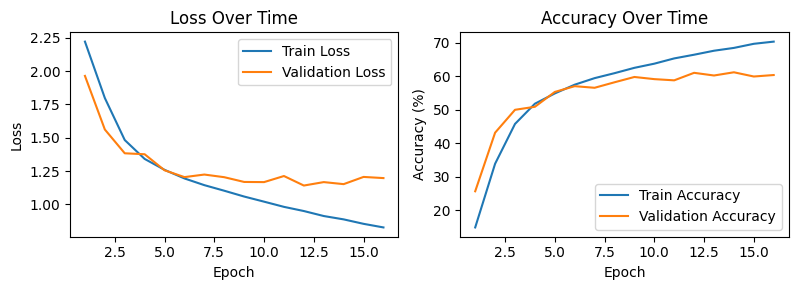

Training with batch_size=8, lr=0.0005, epochs=16
Files already downloaded and verified
Epoch [16/16] Train Loss: 0.901  Train Acc: 68.00% Validation Loss: 1.109  Validation Acc: 61.66%


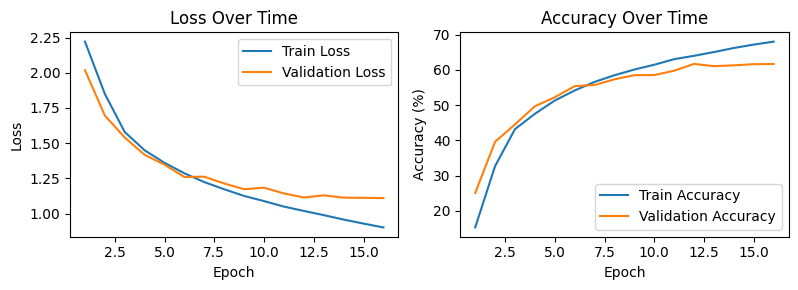

Training with batch_size=8, lr=0.0001, epochs=16
Files already downloaded and verified
Epoch [16/16] Train Loss: 1.441  Train Acc: 48.05% Validation Loss: 1.428  Validation Acc: 48.62%


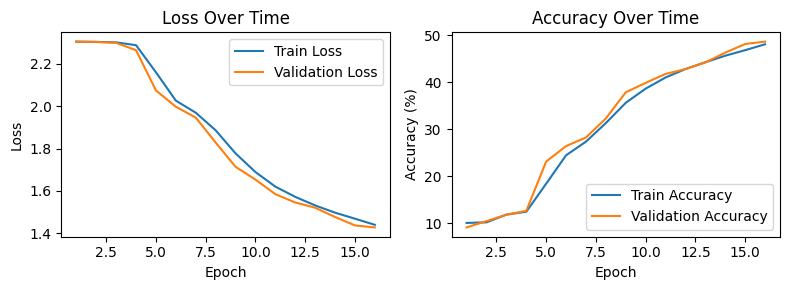

Training with batch_size=8, lr=5e-05, epochs=16
Files already downloaded and verified
Epoch [16/16] Train Loss: 1.668  Train Acc: 40.10% Validation Loss: 1.617  Validation Acc: 42.94%


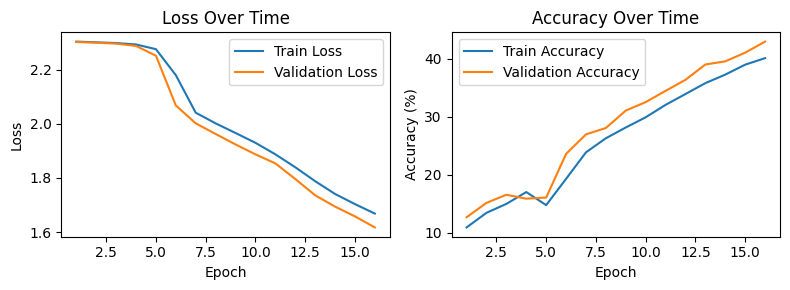

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split

# Define the network architecture (you can modify this if needed)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Define a function to train and evaluate the network
def train_and_evaluate(batch_size, learning_rate, num_epochs):
    # Define transformations and data loaders
    transform = transforms.ToTensor()
    trainset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=True, download=True, transform=transform)

    # Split the dataset into a training set and validation set
    validation_size = 5000
    new_training_size = len(trainset) - validation_size
    new_trainset, validationset = random_split(trainset, [new_training_size, validation_size])

    # Create data loaders for the new training set and validation set
    new_trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Create and initialize the model
    net = Net()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []  # To store training losses
    validation_losses = []  # To store validation losses
    train_accuracy = []  # To store training accuracy
    validation_accuracy = []  # To store validation accuracy

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        net.train()  # Set the model in training mode

        for i, data in enumerate(new_trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(new_trainloader))
        train_accuracy.append(100 * correct_train / total_train)

        # Validation loss and accuracy
        net.eval()  # Set the model in evaluation mode
        correct_val = 0
        total_val = 0
        validation_loss = 0.0

        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_losses.append(validation_loss / len(validationloader))
        validation_accuracy.append(100 * correct_val / total_val)
        if epoch == num_epochs-1:
          print(f'Epoch [{epoch + 1}/{num_epochs}]'
              f' Train Loss: {train_losses[-1]:.3f} '
              f' Train Acc: {train_accuracy[-1]:.2f}%'
              f' Validation Loss: {validation_losses[-1]:.3f} '
              f' Validation Acc: {validation_accuracy[-1]:.2f}%')


    # Plotting loss and accuracy
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Time')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracy, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Over Time')

    plt.tight_layout()
    plt.show()

# Specify the hyperparameters to search over
batch_sizes = [4, 8]
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5]
epochs = [16]

# Nested loops to search over hyperparameters
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for num_epochs in epochs:
            print(f"Training with batch_size={batch_size}, lr={learning_rate}, epochs={num_epochs}")

            # Call the training function for the current hyperparameters
            train_and_evaluate(batch_size, learning_rate, num_epochs)



-----
### 1) What are the choices that could be empirically ignored without doing any experiments?Were you correct after you conduct the experiments?
The epoch number 1 and 2 were never considered as suitable even if i never experiment before because  it doesn't give the model any chance to learn from the data effectively. and high probably it can not capture the underlying patterns or features in the data, leading to underfitting and high loss value.
After conducting the experiments,it turns out that it indeed not enough for model to learn.

### 2)How many epochs are passed when the network is converged?
It really depends.When u use different learning rates and batch sizes,the epochs it takes to converged is different,but generally it is converged 5 to 7 epochs are passed.

### 3)Why too large or too small learning rates are not good choices?
Neither too big nor too small learning rate is good choice.When the learning rate is too large like 0.005,it could lead to the loss function diverging and make the training process unstable.If using the learning rate of 0.00001(too small),it leads to extremely slow convergence. The model accuracy makes tiny progress after each batch, which requires many many epochs to reach a reasonable solution.  

### 4)What are the specification of the computer you are using? E.g. the cpu/gpu type and the corresponding memory.
CPU: Intel(R) Core(TM) i5-9300H

GPU: NVIDIA GeForce GTX 1660 Ti

### 5)How long do you run an epoch? Did you use samples of the original dataset to speed up your progress, and how did it work?
It takes about 92 seonds to run an epoch on average.I did not use it.

### 6)Are there any overfitting problems?
Yes,there are some overfitting probems and they usaually happened at epoch 5 or epoch 6.When they happened,the validation accuracy improved slow while the train accuracy increasing fast.  

### Part 3: More options

Please indicate the **three** tasks you are assigned here:

1) Transformation: CenterCrop/FiveCrop+Resize

2) Structure: Pooling method

3) Training procedure: lr scheduler: Exponential

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
1)The main difference between new baselien and old  one is that I changed the CenterCrop to RandomCrop and added Flip to transforamtion:
        
        transforms.CenterCrop(32),  # RandomCrop with padding
        transforms.Resize(32),  # Resize
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
The Centercrop can be very useful when we want to focus the model on the central region of the image.However, it doesn't introduce variation into the training data, which could be a disadvantage if the model needs to be robust to translations and different views.

To solve this probelm,,I introduce RandomFlip to enhance Dataset Diversity and reduce Overfitting futher and it turned out that the modifcation made was very effective,which takes the validation accuracy from 70% to 76% and the overfitting problem was solved.

Modification output:
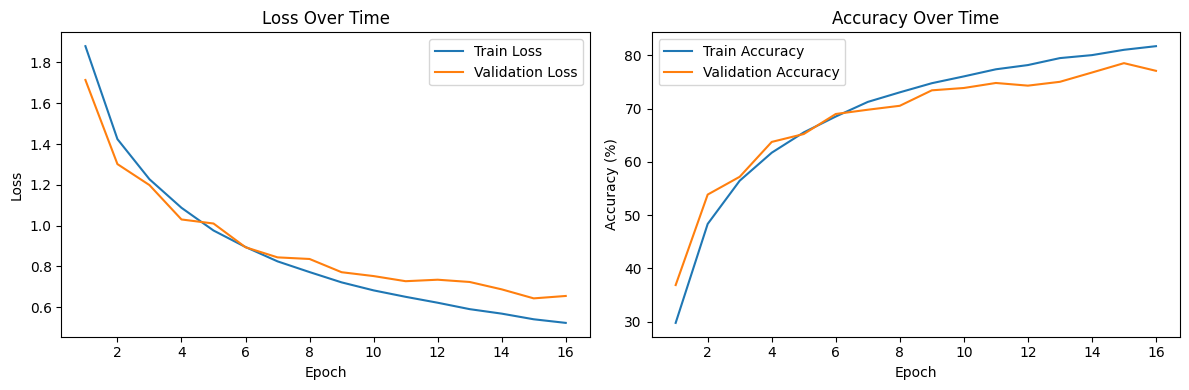



_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis.

##### your analysis comes here:
-----
## 1)CenterCrop+Resize:

CenterCrop is used to extract a fixed central portion (crop) of the input image.Focus on the most informative region of the image.The cifar-10's target are usually in middle of images so it is useful.However, it bring seldom variation.so I add a flip tp it to eliminate ooverfitting. The Resize Function is used to scale the images to the input size expected by  model  after cropping.
### CenterCrop(24):
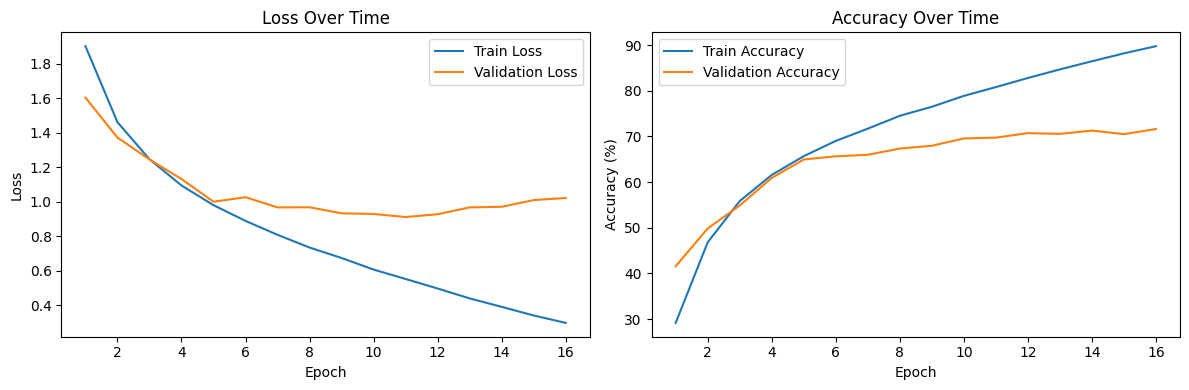
##Without Centercrop:
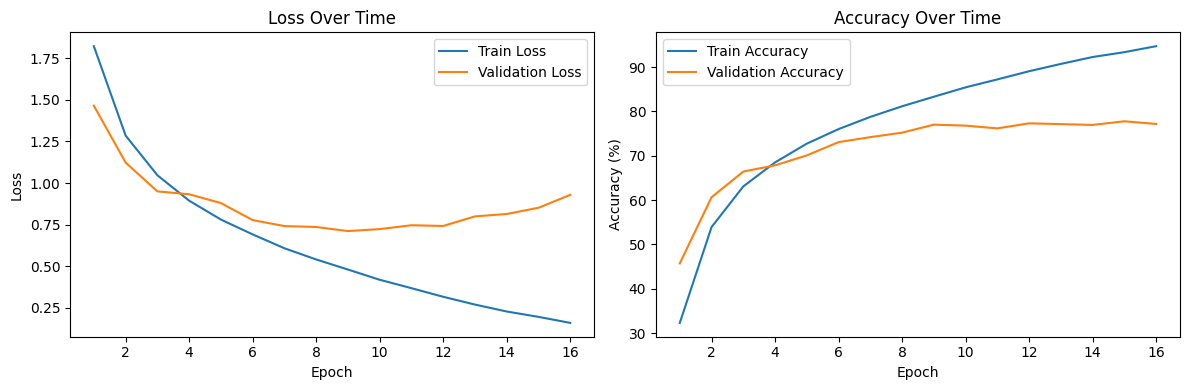
From above picture we can see that the one without centercrop perform better than the other one,which not meets my expectation.So i changed centercrop(31)and do another try.
###CenterCrop(31):
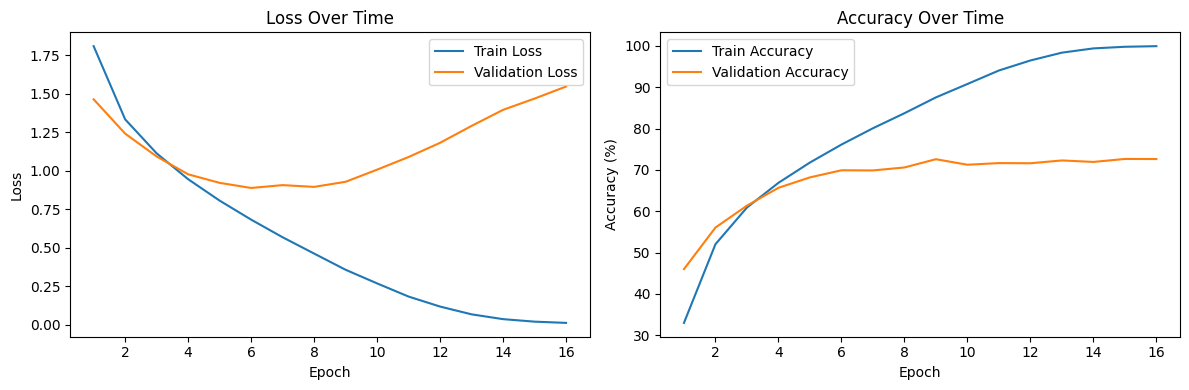
###CenterCrop(32)
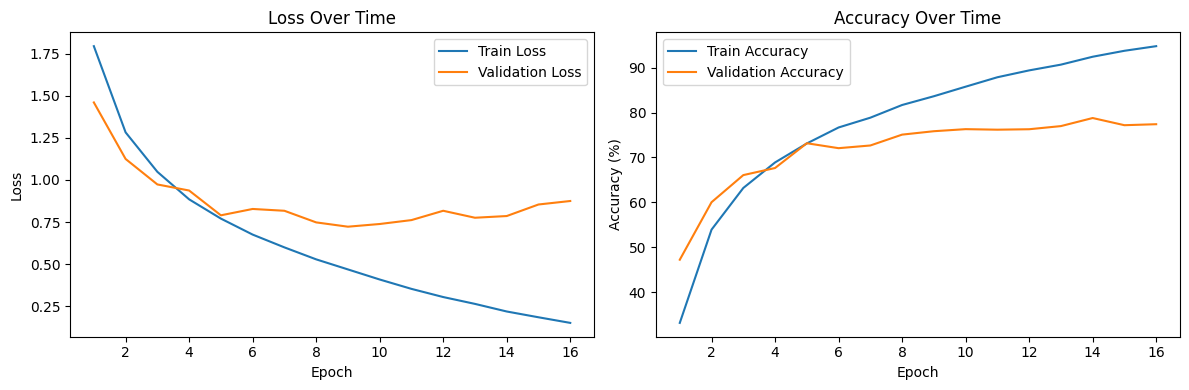
We make comparison and find that when the number in Centercrop close to 32,whcih is the size of input image of Cifar-10,the model performs better. My assumption is that the ciar-10 image is very good quality and do not need any further modification,when i did CenterCrop, it would only lose inforamtion and led to bad model performance.
## 2)Pooling method:

Pooling method is used to reduce the size and complexity of feature maps.In part3, i choose to use Average pooling.For Maxpooling, The maximum value is selected and retained in the output.

### Maxpooling example:

### Input:         ############### #####Output:          

### [1, 2, 1, 3],####################[2, 4],   

### [0, 2, 4, 1],####################[2, 4]   
### [2, 1, 0, 2],
### [1, 2, 3, 4]

This helps preserve the most significant features while reducing the size of feature maps and suppress less relavant information.the relevant code is:

def __init__(self):

        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # Add a max-pooling layer after the third convolutional layer
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # Reduced to 512 output channels
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)  # Second fully connected layer with 10 output channels

 I also try Average pooling,whcih is similar to Maxpooling but taking windows and replace the window with the average value.

 ## Average pooling example:

### Input:         ############### ###### Output:          

### [1, 2, 4, 4],####################[3.5, 5.75],   

### [5, 6, 7, 8],####################[1.5, 2.0]   
### [3, 2, 1, 0],
### [1, 2, 2, 2]

###Result of Average Pooling:
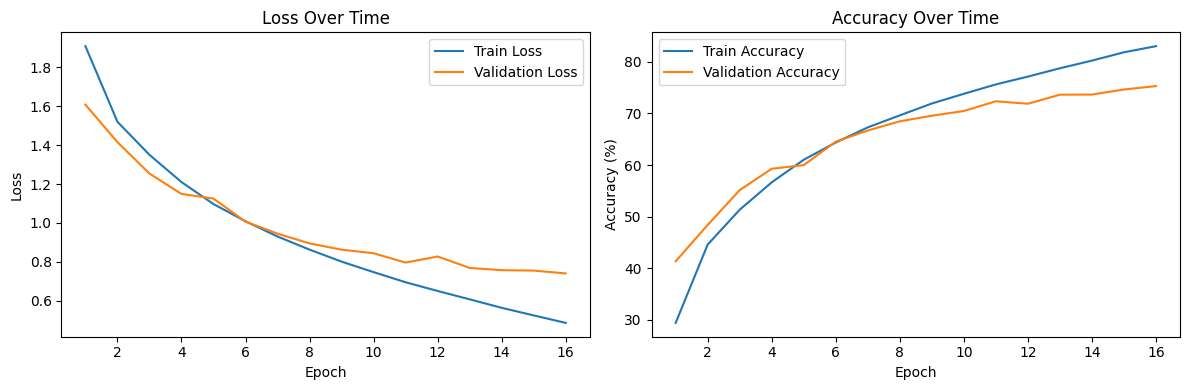
From the result we can see that also maxpooling get a liitel bit higher validation accuracy,the Average pooling upadates very smoothly and avoid overfitting,it is probably because the Average pooling cause less infroamtion loss than Max pooling.
## 3)lr scheduler: Exponential

Big learning rate could make model converging very fast,however it could lead to overfitting.So we introduce the learing rate scheduler:Exponential to gurantee fast initial progress.

As training progresses and the learning rate exponentially decreases, the model shifts towards fine-tuning its parameters and reduce the risk of overfitting.

 The decay rate, controlled by the gamma parameter.The gamma parameter is a positive constant (typically between 0 and 1) that controls the rate at which the learning rate decreases. It is multiplied by the current learning rate at each decay step. For example, setting gamma to 0.95 means that the learning rate will decrease by 5% after each epoch.Smaller gamma values lead to slower learning rate decay, while larger values result in faster decay.After several test i found it most approporiate when gamma=0.95

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)  
###gamma=0.95
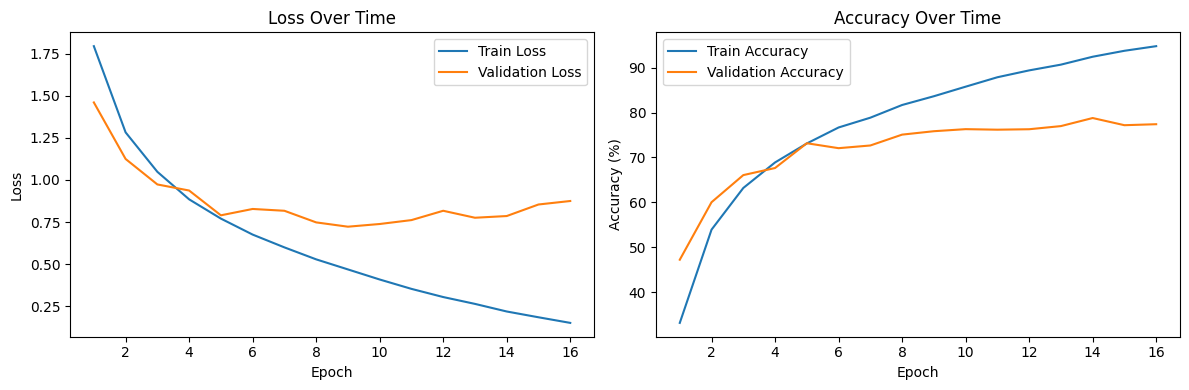
#gamma=0.7
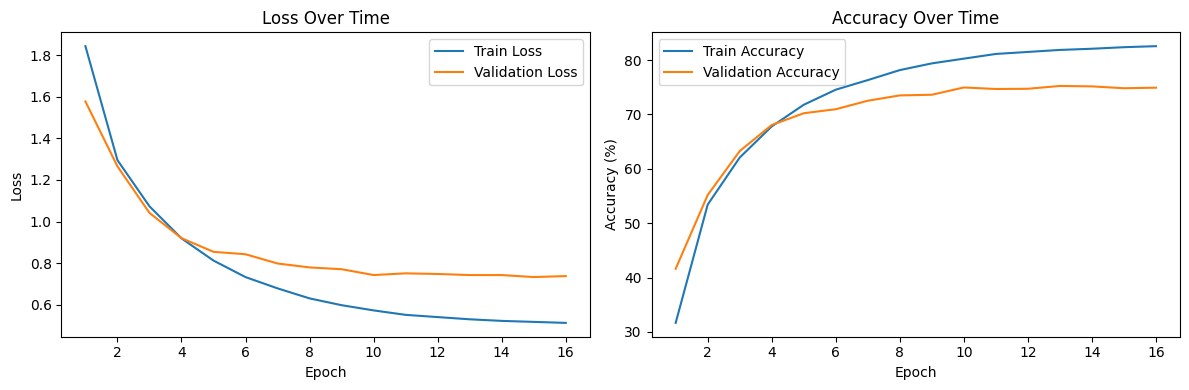
We can see that when gamma =0.7 it avoid overfitting and looks better as fine-tune but its accuracy is a bit lower than gamma=0.95.In able to get higher accuracy, i will choos gamma=0.95

### Reference
1. https://discuss.pytorch.org
2. https://pytorch.org/docs/stable/index.html)
3. https://www.cs.toronto.edu/~kriz/cifar.html

### Specs:

CPU Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz

Memory 8GB

Pytorch Version:2.0.1+cu118

In [ ]:
import torch
print(torch.__version__)


2.0.1+cu118
